# HW 3: Plot Graph Generation (10% of grade)

In this assignment, you will be creating script-like structures called "plot graphs". These plot graphs are probabilistically-created using multiple stories about the same topic.

You will be doing an approximate re-implemention of **the Scheherazade system**.  Before doing this homework, please read about the Scheherazade system in the paper [Crowdsourcing Narrative Intelligence](http://www.cogsys.org/journal/volume2/article-2-4.pdf) by Boyang Li, Stephen Lee-Urban, Darren Scott Appling, and Mark O. Riedl (2012). 


Here is an example plot graph that the system creates for *dining at a fast food restaurant*.

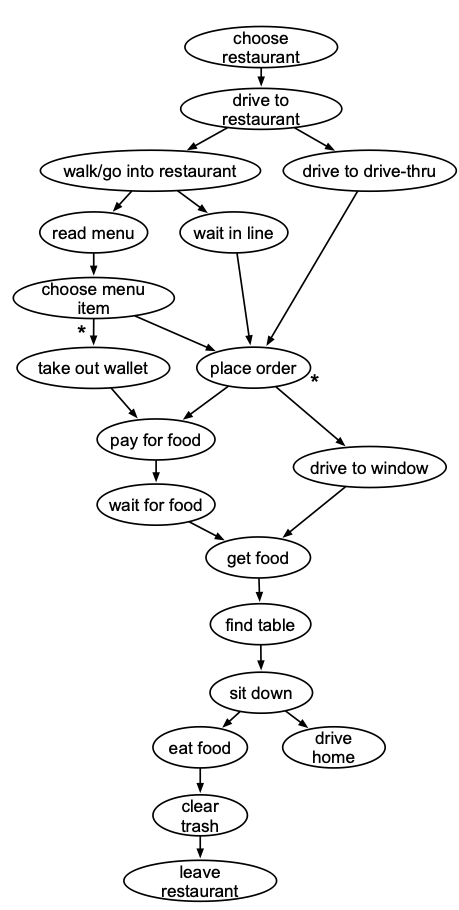


### Further reading
If you're curious how these plot graphs can be used for story generation and interactive fiction, you can read the authors' subsequent papers:
* [Story Generation with Crowdsourced Plot Graphs](https://ojs.aaai.org/index.php/AAAI/article/view/8649)
* [Crowdsourcing Open Interactive Narrative](http://www.boyangli.org/paper/guzdial-fdg15.pdf).




# What you'll be doing
You will create a plot graph using multiple versions of the same basic story.

1. Part 1: Implement the plot graph creation algorithm from _Crowdsourcing Narrative Intelligence_ on their **fast food restaurant scenario**. The algorithm described in the paper creates plot graphs in four steps. We will be grading you on your ability to implement this algorithm as a whole.
```
1) Sentence Similarity
2) Cluster sentences to create events
        Optional: Check purity of clusters
3) Create initial plot graph
4) Script improvement
```

2. Part 2: Run Steps 3 & 4 again using their gold-labeled event clusters instead of the clusters you made.

3. Part 3: Answer some [questions](#questions).

4. [Extra Credit: Use GPT-3 to create a dataset.](#ec)

## Tips

For any part of this homework, feel free to import any library that you might find helpful.

Don't worry about getting your plot graph to look exactly like the one in the paper. Just try your best.

**Spacy Tip:**  For our implementation, we used the spacy library.
If you're using a pre-trained model from the spacy library, I recommend following these instructions to get it to run on colab: https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab

**Visualization tip**. For printing your graph, we gave you a method using pyvis so that you can interact with the graph. You can either use pyvis's graph functionality or networkx to make the graph itself. 

# Part 1: Implement the plot graph creation algorithm from *Crowdsourcing Narrative Intelligence*

## Read in the story data
You just need to run these. Nothing to code here unless you'd like to alter the data structure.

In [ ]:
# get the story files from github
# stories for Part 1
!wget https://github.com/interactive-fiction-class/interactive-fiction-class.github.io/raw/master/homeworks/plots/RtSimpleStories.story
# gold clusters for Part 2
!wget https://github.com/interactive-fiction-class/interactive-fiction-class.github.io/raw/master/homeworks/plots/RtSimpleGold.gold

In [ ]:
def initData(story_filename):
  """
  Read story file and make a list of stories,
  where each story is a list of sentences
  You're welcome to alter this method to better
  suit your needs.
  """
  all_stories = []
  stories = open(story_filename,'r') 
  curr_story = []
  for storyline in stories.readlines():
    if "###" in storyline:
      all_stories.append(curr_story)
      curr_story = []
    else:
      sentence = " ".join(storyline.split(" ")[1:]).strip()
      curr_story.append(sentence)
  stories.close()
  return all_stories

stories = initData('RtSimpleStories.story')

Here is an example of one the 32 stories in the `RtSimpleStories.story`.

```
['Sally drove to the restaurant .',
 'Sally walked into the restaurant .',
 'Sally decided what to order .',
 'Sally waited in line .',
 'Sally ordered what Sally decided earlier .',
 'Sally waited for her food .',
 'Sally took her food to her table .',
 'Sally sat down .',
 'Sally ate her food .',
 'Sally throwed away her trash .',
 'Sally drove home .']
 ```

# Part 2: Rerun steps 3 & 4 on the gold-labeled event clusters
When you get to this part, you will have to edit your code in the **The Scheherazade Plot Graph Algorithm** section to take in these clusters instead of the ones you made.

In [ ]:
def getGoldClusters():
  goldFile = open('RtSimpleGold.gold','r')
  golds = {}
  curr_cluster = []
  curr_label = ""
  for storyline in goldFile.readlines():
    if "@" in storyline:
      sentence = " ".join(storyline.split(" ")[1:]).strip()
      curr_label = sentence
    elif "###" in storyline:
      golds[curr_label] = curr_cluster
      curr_cluster = []
    else:
      sentence = " ".join(storyline.split(" ")[1:]).strip()
      curr_cluster.append(sentence)
  goldFile.close()
  return golds

golds = getGoldClusters()

# The Scheherazade Plot Graph Algorithm
For Parts 1 & 2

## 1) Sentence Similarity

Create a method that calculates the semantic similarity between sentences. They use WordNet + Resnik to find the distances between words, but you can use word vectors or something else.





In [ ]:
#Pick one of the two following methods or use your own!

def vector_similarities(stories):
  story_vectors = [] #flattened list of sentence vectors
  vectors = #TODO: your vector model of choice
  for story in stories:
    for sent in story:
      curr_sent = []
      sent = sent.replace(".","").strip()
      for word in sent.split():
        v = #TODO: vector
        curr_sent.append(v)
        array = np.array(curr_sent)
      word_avg = np.mean(array, axis=0)
      story_vectors.append(word_avg)

#OR
def pairwise_similarity(sentence1, sentence2):
  # TODO: compare 
  return similarity


## 2) Cluster Sentences

Pick your favorite clustering algorithm. In the paper, they use OPTICS.

In [ ]:
def cluster(stories):
  clusterer = None #TODO: clustering algorithm
  predictions = {} #TODO: for each vector, predict what cluster it belongs to (if you used vectors)

  clusters = defaultdict(list)
  flattened_sents = [sent for story in stories for sent in story]
  for i, sent in enumerate(flattened_sents):
    clusters[predictions[i]].append(sent)
  return clusters

#(Optional) TODO: use purity equations to improve clusters (see paper)

## 3) Create Initial Plot Graph

You're going to start the graph by connecting all of the nodes together.

To do this, you will first calculate a confidence value.
For each pair of **sequential** (one after the other) events e1 & e2, compute the confidence of `before(e1,e2)`:

$confidence = \sum_{i=1}^k{{n \choose i}\frac{1}{2^n}}$

where n is the number of observations supporting either before(e1, e2) or the opposite hypothesis before(e2, e1), and k is the observations that support before(e1, e2).


If the confidence is > 50% (0.5), accept it as `before(e1, e2)`.
Otherwise, accept `before(e2, e1)`


In [ ]:
%%capture
!pip install pyvis

In [ ]:
from pyvis.network import Network
def drawGraph(graph, filename):
  net = Network(notebook=True, directed=True)
  net.from_nx(graph)
  net.show(filename)

In [ ]:
import networkx as nx
from copy import deepcopy

plotgraph = nx.DiGraph()
plotgraph.add_nodes_from(clusters.keys())
for e1 in clusters.keys():
  for e2 in clusters.keys():
    if plotgraph.has_edge(e1,e2): continue
    if e1 == e2: continue #no self-loops
    #calculate confidence of before(e1,e2)
    #n = number of observations supporting either before(e1, e2) or the opposite hypothesis, before(e2, e1)
    #k = observations that support before(e1, e2)
    n = 0
    k = 0
    for story in stories:
      pass # TODO: initialize graph

drawGraph(plotgraph, "plotgraph.html")


#########################################
# "For a simple loop that does not share edges with other loops, we break the loop 
# by removing the lowest confidence edge in the loop"
slimgraph = deepcopy(plotgraph)
loops = nx.simple_cycles(slim_graph)
for loop in loops:
  min = 1000
  min_pair = ()
  #find least confident edge and remove it
  for i,node in enumerate(loop):
    pass # TODO: simplify graph


drawGraph(slimgraph, "slimgraph.html")



## 4) Improve Plot Graph

In their words, this is
> a heuristic procedure that restores missing before relations by analyzing the impact of each relation on the global script structure. To make the procedure robust against parameter selection, we use a high threshold, which leads to missing relations, together with this procedure to restore them. We optimize the script structure by minimizing an error metric, which accounts for differences in the script structure and crowdsouced narrative examples.



### a) Calculate DN, DG, and MSGE

Next, you will be calculating the mean squared graph error (MSGE). This will help you improve the graph by making sure your additions don't increase MSGE.

In the paper, DN(e1,e2) is described as:
> the normative distance from e1 to e2 averaged over the entire set of narratives. For each input narrative that includes sentence s1 from the cluster representing e1 and sentence s2 from the cluster representing e2, the distance (i.e. number of interstitial sentences plus  one) between s1 and s2 is dN(s1, s2). DN(e1, e2) is thus the average of dN(s1, s2) over all such input  narratives.

DG(e1,e2) is 
>the number of events on the shortest path from e1 to e2 on the graph (e1 excluded)

Then you combine the two for the MSGE equation:

$MSGE = \frac{1}{|P|}\sum_{e_1 \in P}{\sum_{e_2 \in P}{(D_G(e_1,e_2)-D_N(e_1,e_2))^2}}$

where P is the set of all ordered event pairs (e1, e2) such that e2 is reachable from e1 or that they 
are unordered.

In [ ]:
from collections import defaultdict


def getDN(stories):
  #TODO: calculate DN
  DN = {}
  return DN

def getDG(DN,graph):
  #TODO: calculate DG
  DG = {} # DG(e1, e2) is the number of events on the shortest path from e1 to e2 on the graph (e1 excluded)
  return DG

def calculateMSGE(DN, DG):
  #TODO: calculate MSGE
  MSGE = 0
  return MSGE

def callMSGE(stories,graph):
  DN = getDN(stories)
  DG = getDG(DN,graph)
  MSGE = calculateMSGE(DN,DG)
  return MSGE


callMSGE(stories,plotgraph)

### b) Add on to the Graph

Now you will use DG, DN, and MSGE, to add onto your existing graph by following this algorithm (from Table 3 in Crowdsourcing Narrative Intelligence):

```
Q := all of events (e1, e2) such that e2 is reachable from e1 or unordered 
Foreach (e1, e2) ∈ Q in order of decreasing DN(e1, e2) – DG(e1, e2) do:
  E := the set of event ei that satisfy DG(e1, ei) = DN(e1, e2) – 1 
  Foreach ei ∈ E do:
    If edge ei → e2 is not in the graph and adding it to the graph will not create a cycle do:
      Add ei → e2 to the graph
Return graph
```

In [ ]:
from copy import deepcopy


DN = getDN(stories)
DG = getDG(DN,plotgraph)
MSGE = calculateMSGE(DN,DG)

Q = 0
newgraph = deepcopy(slimgraph)
# TODO: implement above algorithm

drawGraph(slim_graph, "filled.html")


# Part 3: Questions
<a name="questions"></a>
1. How do these two plot graphs differ? Do they have any similarities?
2. How does the gold-labeled clusters plot graph compare to the one in the paper?
3. About how many plot graphs do you think we would need in order to create a system that could tell a story about anything? Why?
4. How feasible do you think it is to generate a bunch of these types of plot graphs? What kinds of resources do you think you would need?
5. Beyond story/IF generation, what types of real-world scenarios can you see this technology being used for?


# Extra Credit
<a name="ec"></a>
Use GPT-3 to generate a bunch of short stories about John and Sally eating at a fast food restaurant, and use this as your input.


- How does the plot graph made from your GPT dataset compare to the story file we gave you (with the clusters you made)?

  a. Is one graph easier to read than the other? Why?

  b. Which one do you think will create better stories? Why?